In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install ALE
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Packages

In [ ]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch
import torch.utils
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset, random_split
import gym
import numpy as np
import pickle
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Pytorch Dataset

In [ ]:
class ExpertDataSet(Dataset):
    def __init__(self, expert_observations, expert_actions):
        self.observations = expert_observations
        self.actions = expert_actions
        self.img_transforms=transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, index):
        return (self.img_transforms(self.observations[index]), self.actions[index])

    def __len__(self):
        return len(self.observations)

## Neural Network

In [ ]:
class ImitationAgent(nn.Module):
  def __init__(self, num_actions, batch_size=64):
    super(ImitationAgent, self).__init__()
    self.batch_size = batch_size

    self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2))
    self.layer3 = nn.Sequential(
        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU())
    self.layer4 = nn.Sequential(
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU())
    self.layer5 = nn.Sequential(
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2))
    self.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(3840, 4096),
        nn.ReLU())
    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU())
    self.fc2= nn.Sequential(
        nn.Linear(4096, num_actions))

  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = self.layer5(out)
      out = out.reshape(out.size(0), -1)
      out = self.fc(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out,F.softmax(out, dim=1)

  def act(self, state):
      # Stack 4 states
      state = torch.vstack([self.preproc_state(state) for i in range(1)]).unsqueeze(0)
      
      # Get Action Probabilities
      _,probs = self.forward(state)
      
      
      # Return Action and LogProb
      action = probs.argmax(-1)
      return action.item()
    
  def preproc_state(self, state):
      # State Preprocessing
      state = state.transpose(2,0,1) #Torch wants images in format (channels, height, width)
      state = torch.from_numpy(state)
      
      return state/255 # normalize
        
        
    

## Train

In [ ]:
objects = []
with (open("/content/drive/MyDrive/Colab Notebooks/RL/Project/expert_tracefirst_final.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

obs = objects[0][0]
act = objects[0][1]

expert_dataset = ExpertDataSet(obs, act)


In [ ]:
env = gym.make('MontezumaRevengeNoFrameskip-v4', render_mode='rgb_array')
print("Action balancing")
val = []
exe = []

for action in range(env.action_space.n):
  a = act.count(action)
  print("Action: {} || Execution: {}".format(action,act.count(action)))
  val.append(action)
  exe.append(a) 

Action balancing
Action: 0 || Execution: 405
Action: 1 || Execution: 305
Action: 2 || Execution: 1186
Action: 3 || Execution: 377
Action: 4 || Execution: 597
Action: 5 || Execution: 531
Action: 6 || Execution: 824
Action: 7 || Execution: 396
Action: 8 || Execution: 486
Action: 9 || Execution: 464
Action: 10 || Execution: 193
Action: 11 || Execution: 240
Action: 12 || Execution: 449
Action: 13 || Execution: 522
Action: 14 || Execution: 494
Action: 15 || Execution: 266
Action: 16 || Execution: 368
Action: 17 || Execution: 250


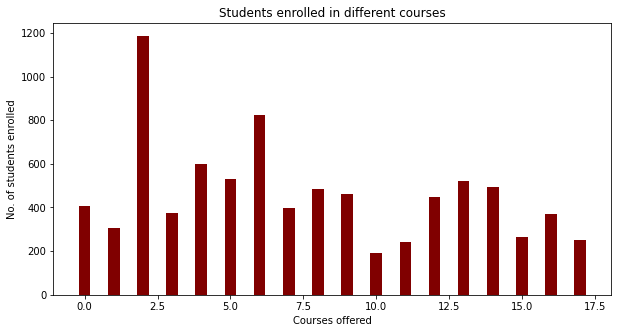

In [ ]:

# creating the dataset

courses = val
values = exe
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.show()

In [ ]:
print("Expert interactions size: ", len(obs))
print(len(act))

Expert interactions size:  8353
8353


In [ ]:
for i in range(10):
  act.pop()

In [ ]:
# Define relevant variables for the ML task
learning_rate = 0.001
num_epochs = 30
num_workers = 2
batch_size = 640
train_prop = 0.7
train_size = int(train_prop * len(expert_dataset))
test_size = len(expert_dataset) - train_size

In [ ]:
train_expert_dataset, test_expert_dataset = random_split(expert_dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(  dataset=train_expert_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(  dataset=test_expert_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
batch_limit = len(train_loader)

In [ ]:
student = ImitationAgent(env.action_space.n)
student.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


for epoch in range(num_epochs):
    for batch, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        results,_ = student(images)
        loss = criterion(results, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('Epoch {}/{} | Batch {}/{} | Training Loss: {:.4f}'.format(epoch+1, num_epochs, batch+1, batch_limit, loss.item()))

        if epoch % 100 == 0:
          net_checkpoint = "/content/drive/MyDrive/Colab Notebooks/RL/Project/imit"+str(epoch+1)+".pt"
          torch.save(student.state_dict(), net_checkpoint)

net_checkpoint = "/content/drive/MyDrive/Colab Notebooks/RL/Project/imit_final.pt"
torch.save(student.state_dict(), net_checkpoint)

Epoch 1/30 | Batch 1/10 | Training Loss: 2.9183
Epoch 1/30 | Batch 2/10 | Training Loss: 2.9325
Epoch 1/30 | Batch 3/10 | Training Loss: 2.8967
Epoch 1/30 | Batch 4/10 | Training Loss: 2.8638
Epoch 1/30 | Batch 5/10 | Training Loss: 2.8444
Epoch 1/30 | Batch 6/10 | Training Loss: 2.8005
Epoch 1/30 | Batch 7/10 | Training Loss: 2.7762
Epoch 1/30 | Batch 8/10 | Training Loss: 2.7559
Epoch 1/30 | Batch 9/10 | Training Loss: 2.8307
Epoch 1/30 | Batch 10/10 | Training Loss: 2.8029
Epoch 2/30 | Batch 1/10 | Training Loss: 2.7452
Epoch 2/30 | Batch 2/10 | Training Loss: 2.8250
Epoch 2/30 | Batch 3/10 | Training Loss: 2.7224
Epoch 2/30 | Batch 4/10 | Training Loss: 2.8015
Epoch 2/30 | Batch 5/10 | Training Loss: 2.7814
Epoch 2/30 | Batch 6/10 | Training Loss: 2.7637
Epoch 2/30 | Batch 7/10 | Training Loss: 2.7900
Epoch 2/30 | Batch 8/10 | Training Loss: 2.7368
Epoch 2/30 | Batch 9/10 | Training Loss: 2.7331
Epoch 2/30 | Batch 10/10 | Training Loss: 2.7355
Epoch 3/30 | Batch 1/10 | Training Los

In [ ]:
images.detach()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        